# Understanding Overfitting and Underfitting

Now that we have understood a bit more about how to build a classification model and evaluate the model on said data, we will now see how overfitting and underfitting take effect. How we can ensure that our model classifies data effectively but also generalizes the data so as to not be overly defined to the training data. This is a really important aspect of machine learning models.

In both the previous models that we made, we could see that the validation accuracy usuallly peaked at a certain epoch and then either stagnated or even decreased. This is happens when the model becomes overfitted to some training data and starts to learn the noise associated with the training data as well. The opposite of this is called underfitting, where the model still has room to imporve its accuracy by using the training data. Let us now look at ways that we can prevent both underfitting and overfitting.


## Overfitting

The best way to prevent overfitting is to use a more complete set of test data. A model trained on such data will naturally generalize better. This depends on our training data however. The next best thing we can do when we do not have access to such data is techniques such as regularization. This places contraints on the quantity and the tpy od information your model stores and therefore the model is forced to only focus on the important bits for learning patters in the data. This gives the model a better chance of generalizing to other data better. LEt see how this can be accomplished

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Lets now unpack our data. We will be using the Higgs Dataset which contains 11 000 000 samples, each with 28 different features and a binary class label.

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [6]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

What we are doing with the above step is unpacking the compressed data directly in a punch of lists of scalar values. These are then packed back into (feature_vector, label) pairs using the below function.

In [7]:
type(ds)

tensorflow.python.data.experimental.ops.readers.CsvDatasetV2

In [8]:
def pack_row(*row): #we pass the function in using the map function, therefore the row variable is the row that will be seen as a result of the mapping function
    label = row[0]
    feature = tf.stack(row[1:],1) #stack row 1 along axis 1
    return feature, label

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


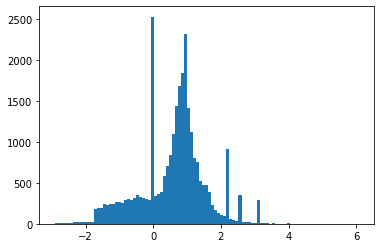

In [10]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

Let us use the first 1000 samples for validation and the next 10k for training:


In [11]:
N_VAL = 1000
N_train =10000
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_train//BATCH_SIZE


We will use the Dataset.skip and Dataset.take methods to easily get our required data into thier own repsective sets. Next we will use the Dataset.cahce method to ensure that the loader doesn't need to re-read data every epoch. Basically we intend to take data straight from the dataset rather then making two new variables that store the training and validation sets.

In [12]:
validate_ds = packed_ds.take(N_VAL).cache()
train_ds = packed_ds.skip(N_VAL).take(N_train).cache()
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [13]:
validate_ds = validate_ds.batch(BATCH_SIZE) #Batch into sizes BATCH_SIZE
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BUFFER_SIZE) #shuffle then batch

OK, Now lets demostrate overfitting and its solutions. 

The simplest way to prevent overfitting is to use a smaller model. This is reffered to as the model's capacity. A model with more parameters will intuitively have more "memorization capacity" and therefore learn training data very easily, but this is not helpful when we want to then predict labels for new unseen data. The real challenge in deep-learning is to generalize, not fit.

On the other hand. If the model has limited memorization capability, then it will not be able to learn the training mapping easily. Thus in order to learn patterns in the data, we would need use compressed representations that have more predictive power. Once your model has too little capacity, it starts to become impossible for the model to learn anything at all. 

Unfortunately, reaching this 'goldylocks zone' is something that can only be done through trial and error. 
Therfore to understand how the size of the model affects the performance, we would start with a reltively small model, then build up slowly until we start seeing diminished performance.

Many models train better if you gradually reduce the learning rate during training. Use optimizers.schedules to reduce the learning rate over time:

In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase = False,
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The schedule code sets the learning rate to decrease hyperbolically every 1000 epochs. See plot below:


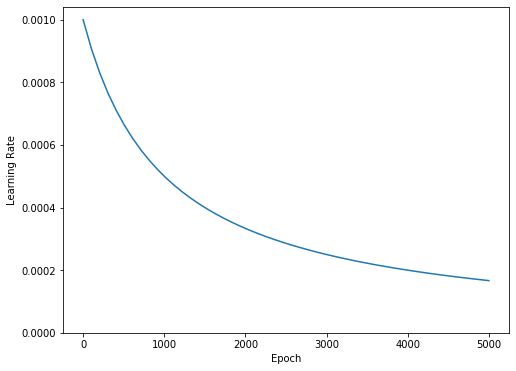

In [15]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Since each training environment will use the same configuration, it is beneficial to set up in a reproducable way using a list of callbacks. 

We will use tfdocs.EpochDots to print a simple progress bar for training

We will be monitoring the val_binary_crossentropy metric with this callback



In [16]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [17]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics = [
                        tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                        'accuracy'
                    ])

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    return history

Ok, so we have now set up a reproducable set of training configurations as well as a system of setting up our model and training it quite fast and easily. LEt us now jump into simulating models of various sizes and seeing how the number of parameters in a model makes a difference to the performance.

In [18]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [19]:
size_histories = {}

In [20]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4993,  binary_crossentropy:0.8880,  loss:0.8880,  val_accuracy:0.4680,  val_binary_crossentropy:0.8396,  val_loss:0.8396,  
....................................................................................................
Epoch: 100, accuracy:0.6348,  binary_crossentropy:0.6046,  loss:0.6046,  val_accuracy:0.6130,  val_binary_crossentropy:0.6094,  val_loss:0.6094,  
....................................................................................................
Epoch: 200, accuracy:0.67

(0.5, 0.7)

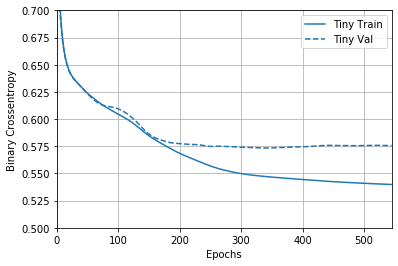

In [21]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

We can repeat this process with greater model sizes by increasing the number of parameters on each.

In [29]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [30]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4952,  binary_crossentropy:0.7581,  loss:0.7581,  val_accuracy:0.4730,  val_binary_crossentropy:0.7339,  val_loss:0.7339,  
....................................................................................................
Epoch: 100, accuracy:0.6973,  binary_crossentropy:0.5545,  loss:0.5545,  val_accuracy:0.6490,  val_binary_crossentropy:0.5984,  val_loss:0.

In [31]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [32]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4792,  binary_crossentropy:0.6944,  loss:0.6944,  val_accuracy:0.4930,  val_binary_crossentropy:0.6723,  val_loss:0.6723,  
....................................................................................................
E

In [33]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [34]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5049,  binary_crossentropy:0.8225,  loss:0.8225,  val_accuracy:0.5480,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

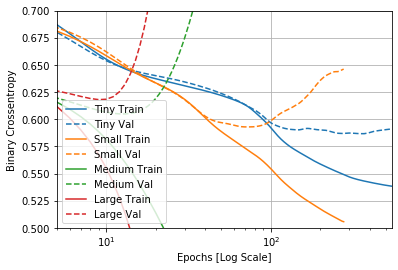

In [35]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

My models suck lol, they all overfit so quickly. Accuracies are fine though.

## Prevent Overfitting

Let us now look at some techniques that may be used to prevent overfitting completely. We will use the baseline from the 'Tiny' dataset to use as a comparison

In [22]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularisers/Tiny')

PosixPath('/tmp/tmpcnj5bjb1/tensorboard_logs/regularisers/Tiny')

In [23]:
regularizers_histories ={}
regularizers_histories['Tiny'] = size_histories['Tiny']

### Weight Regularization

Using logic from Occam's Razor, we can say that simpler neural networks with less weights are less likely to overfit to training data than larger models. Another way to define a simple model is to say that the simpler the model, the less entropy in its parameters. Therefore a common way to prevent overfitting is to put constraints on how complex a model can become by forcing the weights to only take small values, resulting in a more regular weight distribution. Thus this technique is call "weight regularization"

This is done by adding increased cost to having larger weights in the cost function. This can be done through:

1. **L1 Regularization** L1 norm of weights. Cost is added proportional to the absolute value of the weights. This takes into account the magnitude and direction (sign) of the weights.
2. **L2 Regularization** Cost is added proportional to the square of the distance, thus only taking in acount of the absolute value of distance.

L1 tends to make the weights go to zero, whereas L2 makes the weights become small without being sparse. Therefore L2 tends to be more widely used. L2 regularization is also known as weight decay. Let us now add regularization to our models.

In [24]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizers_histories['L2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5166,  binary_crossentropy:0.7980,  loss:2.3086,  val_accuracy:0.4760,  val_binary_crossentr

(0.5, 0.7)

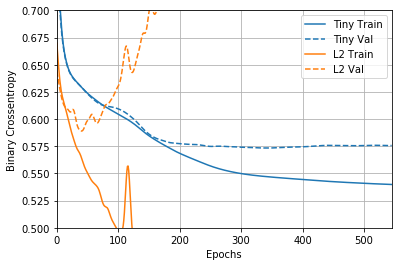

In [25]:
plotter.plot(regularizers_histories)
plt.ylim([0.5, 0.7])

In this regualrization we will add 0.001 * weight_coefficeint_value^2 to the loss of the network.

Here we can see that the regularized model is as resistant to overfitting as teh tiny model despite having the same number of parameters as the large model it was based on. When writing custom training loops using these models, make sure that you ask the model for its regularization loss.


In [26]:
results = l2_model(features)
regulalarization_loss = tf.add_n(l2_model.losses)

Secondly, the implementation first adds weight penalities to the loss then optimizes. A second approach is to run the optimization on the raw loss (non-regularized), then add weight decay when calculating the step that will be taken to minimize the raw loss. This is achieved in tf using a different optimizer

### Dropout

Dropout is the most effective and commonly used regularization technique fro neural networks. Basically what happens is that you remove random connections between nodes, thus each node is forced to optimize in such a way that it optimizes its own self rather than itself reletive to other nodes. Thus the complex relationship between nodes is minimized, preventing eventual overfitting.



In [27]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizers_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

(0.5, 0.7)

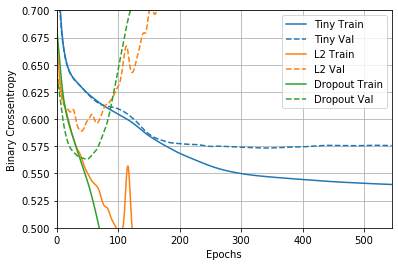

In [28]:
plotter.plot(regularizers_histories)
plt.ylim([0.5, 0.7])


Again it can be seen that the model perform better than the large model, but still not better than the tiny baseline.

### Combined Appraoch

We will not try using both regularization and dropout.

In [29]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizers_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)              

(0.5, 0.7)

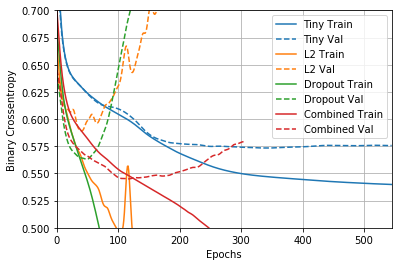

In [30]:
plotter.plot(regularizers_histories)
plt.ylim([0.5, 0.7])

For some reason my model does not seem to match the example used in the tensorflow tutorial online. The validation accuracy of the combined model also seems to not beat our tiny model even though in the tutotrial there is a significant increase in performance. We have however been able to learn how to improve the performance of models using 4 main techniques:

 - Increase the amount of training data
 - Adjust the model size
 - Add weight regularization
 - Add dropout

Further techniques not covered include:
 - data-augumentation
 - batch normalization
